In [19]:
# Automatically reload imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import sys
sys.path.append('..')  # Add parent directory to Python path
from util.data_preprocessing import pad_data_to_30x30, encode_grid, augment_data
from util.model import EnhancedMultiChannelCNN
from util.training import train_model, train_memory
from util.visualization import visualize_loss, visualize_memory, visualize_prediction, visualize_actual


In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [35]:
def read_data(file_name):
  data_path = os.path.join('..', 'data', 'training', file_name)

  with open(data_path, 'r') as f:
    data = json.load(f)

  return data

def prepare_data(file_name):
  data = read_data(file_name)

  augment_data(data)

  # Create tensors directly on GPU
  X = torch.tensor([encode_grid(pad_data_to_30x30(ex['input'])) for ex in data['train']]).to(device)
  Y = torch.tensor([encode_grid(pad_data_to_30x30(ex['output'])) for ex in data['train']]).to(device)

  dataset = TensorDataset(X, Y)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

  # Verify everything is on GPU
  print(f"Using device: {device}")

  return dataloader

def initialize_model():
    # Create model and move to GPU
    model = EnhancedMultiChannelCNN().to(device)
    
    # Initialize criterion
    criterion = nn.CrossEntropyLoss().to(device)
    
    print(f"Model device: {next(model.parameters()).device}")

    return model, criterion

def initialize_memory():
  memory = torch.rand(30, 30, device=device) * 2 - 1

  print(f"Memory tensor device: {memory.device}")
  return memory


Model device: mps:0
Memory tensor device: mps:0
Using device: mps
Epoch [100/1000], Loss: 3.1522
Epoch [200/1000], Loss: 3.1044
Epoch [300/1000], Loss: 3.0995
Epoch [400/1000], Loss: 3.1235
Epoch [500/1000], Loss: 3.1090
Epoch [600/1000], Loss: 3.1139
Epoch [700/1000], Loss: 3.1269
Epoch [800/1000], Loss: 3.1159
Epoch [900/1000], Loss: 3.1397
Epoch [1000/1000], Loss: 3.0991
Epoch [10/100], Loss: 0.2909
Epoch [20/100], Loss: 0.2684
Epoch [30/100], Loss: 0.2036
Epoch [40/100], Loss: 0.1949
Epoch [50/100], Loss: 0.1857
Epoch [60/100], Loss: 0.2087
Epoch [70/100], Loss: 0.1745
Epoch [80/100], Loss: 0.1101
Epoch [90/100], Loss: 0.1428
Epoch [100/100], Loss: 0.1466


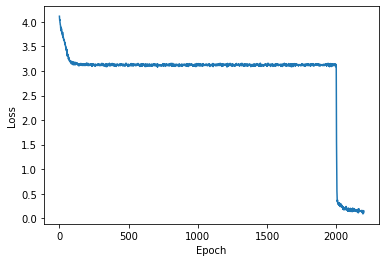

In [29]:
def train(file_name, model, memory, criterion):
  dataloader = prepare_data(file_name)

  loss_history = []

  for i in range(1):
    loss_history.extend(train_memory(model, memory, dataloader, criterion))
    loss_history.extend(train_model(model, memory, dataloader, criterion))

  visualize_loss(loss_history)


model, criterion = initialize_model()
memory = initialize_memory()
train('0a938d79.json', model, memory, criterion)

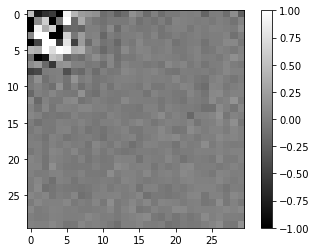

In [31]:
visualize_memory(memory)

In [291]:
# Save the trained model
torch.save(model.state_dict(), 'linear_static_dictionary.pth')

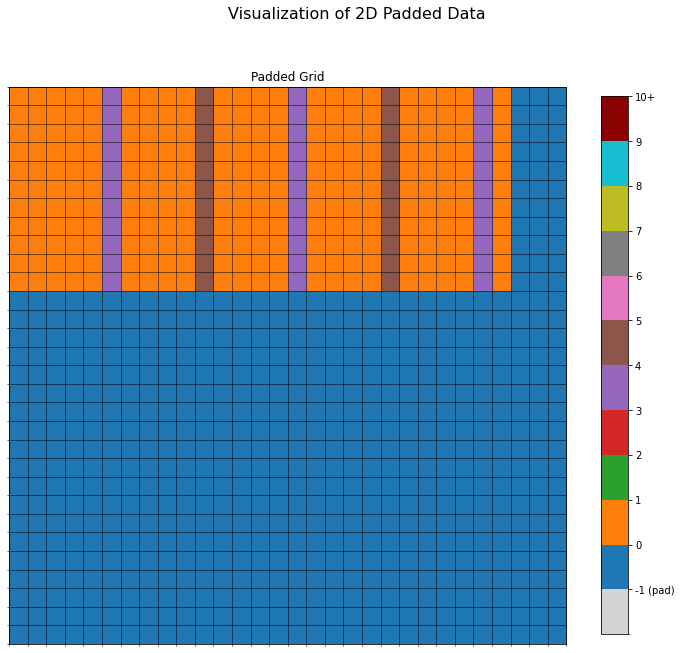

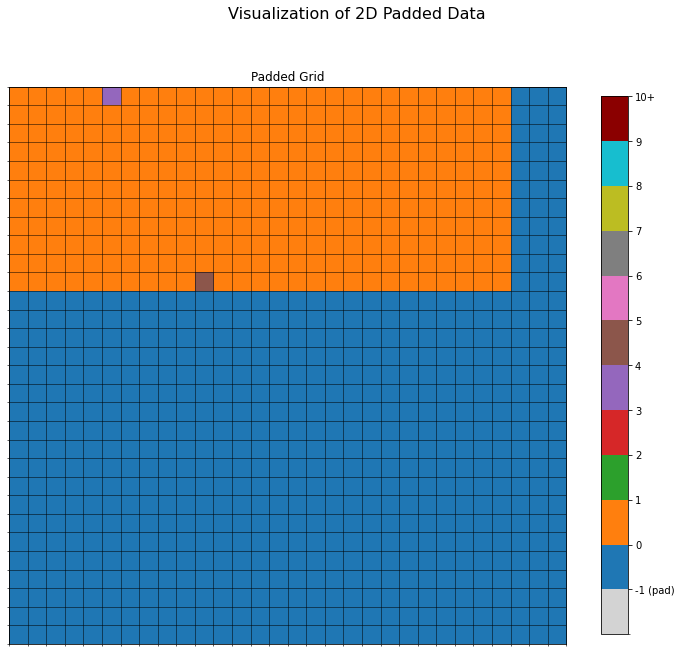

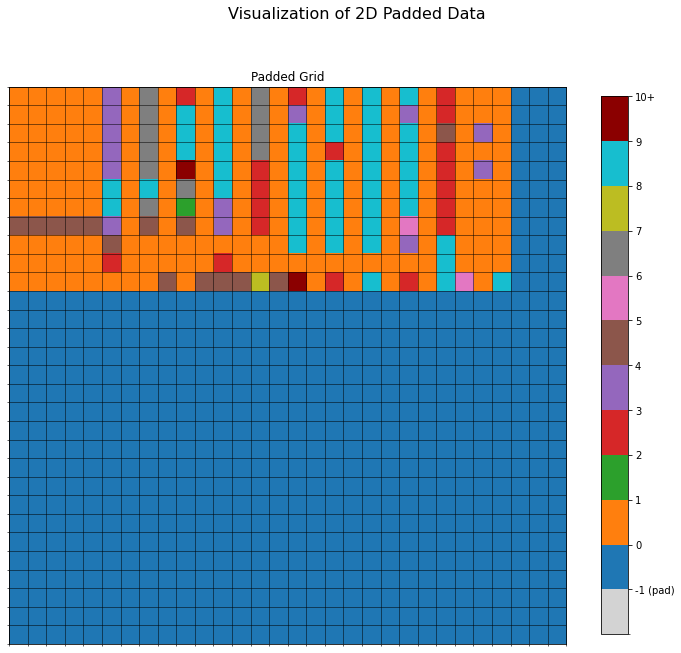

In [36]:
data = read_data('0a938d79.json')

x_test = data['test'][0]
visualize_actual(x_test)
visualize_prediction(x_test['input'], model, memory)
